In [1]:
cd /deac/salsburyGrp/wud18/md/TM/pca/

[Errno 2] No such file or directory: '/deac/salsburyGrp/wud18/md/TM/pca/'
/deac/phy/salsburyGrp/wud18/md/TM/pca


In [2]:
import pyemma
pyemma.__version__

'2.5.6'

In [3]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 18})
pylab.rcParams['figure.figsize'] = (14, 11)
cwd = os.getcwd()

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from pyemma import config
import mdtraj as md
import hdbscan
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in"})

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.6.
  .format(latest=latest, current=current), category=UserWarning)


In [5]:
def plot_free_energy(X,variance,comp1,comp2,type1,type2,type3,vmin,vmax,title,outname):
    cmap = plt.cm.get_cmap("nipy_spectral")    
    cmap.set_bad('white',1.)
    z,x,y = np.histogram2d(X[:,comp1],X[:,comp2], bins=50)
    x = 0.5*(x[:-1] + x[1:])
    y = 0.5*(y[:-1] + y[1:])
    overal_bound = [x[0], x[-1], y[0], y[-1]]
    xLabelName='PC{0} ({1:.2f}%)'.format(comp1+1, variance[comp1] * 100)
    yLabelName='PC{0} ({1:.2f}%)'.format(comp2+1, variance[comp2] * 100)

    fig,ax=plt.subplots(1,3,figsize=(12,5))
    fig.tight_layout(pad=0.1)
    ax=ax.flatten()

    z,x,y = np.histogram2d(X[type1,comp1],X[type1,comp2], bins=50)
    x = 0.5*(x[:-1] + x[1:])
    y = 0.5*(y[:-1] + y[1:])
    extent=[x[0], x[-1], y[0], y[-1]]
    F1 = -np.log(z)
    F1 -= np.min(F1)
    F1[np.where(F1==np.inf)]=np.nan    
    ax0=ax[0].contourf(F1.T, 100, cmap=cmap, extent=extent, vmin=vmin, vmax=vmax)
    ax[0].tick_params(labelsize=14)
    ax[0].set_xlabel(xLabelName, fontsize=16)
    ax[0].set_ylabel(yLabelName, fontsize=16)
    ax[0].set_title(title + ' (thrombin)', fontsize=16)
    ax[0].set_xlim(overal_bound[0],overal_bound[1])
    ax[0].set_ylim(overal_bound[2],overal_bound[3])

    z,x,y = np.histogram2d(X[type2,comp1],X[type2,comp2], bins=50)
    x = 0.5*(x[:-1] + x[1:])
    y = 0.5*(y[:-1] + y[1:])
    extent=[x[0], x[-1], y[0], y[-1]]
    F2 = -np.log(z)
    F2 -= np.min(F2)
    F2[np.where(F2==np.inf)]=np.nan  
    ax1=ax[1].contourf(F2.T, 100, cmap=cmap, extent=extent, vmin=vmin, vmax=vmax)
    ax[1].tick_params(labelsize=14, labelleft=None)
    ax[1].set_xlabel(xLabelName, fontsize=16)
    ax[1].set_title(title + ' (TM56)', fontsize=16)
    ax[1].set_xlim(overal_bound[0],overal_bound[1])
    ax[1].set_ylim(overal_bound[2],overal_bound[3])

    z,x,y = np.histogram2d(X[type3,comp1],X[type3,comp2], bins=50)
    x = 0.5*(x[:-1] + x[1:])
    y = 0.5*(y[:-1] + y[1:])  
    extent=[x[0], x[-1], y[0], y[-1]]
    F3 = -np.log(z)
    F3 -= np.min(F3)
    F3[np.where(F3==np.inf)]=np.nan   
    ax2=ax[2].contourf(F3.T, 100, cmap=cmap, extent=extent, vmin=vmin, vmax=vmax)
    ax[2].tick_params(labelsize=14, labelleft=None)
    ax[2].set_xlabel(xLabelName, fontsize=16)
    ax[2].set_title(title + ' (TM456)', fontsize=16)
    ax[2].set_xlim(overal_bound[0],overal_bound[1])
    ax[2].set_ylim(overal_bound[2],overal_bound[3])

    #cbar=fig.colorbar(ax2, ax=[ax[0],ax[1],ax[2]], orientation='vertical', aspect=25, anchor=(-0.2,0.5))
    #cbar=fig.colorbar(ax[2].contourf(F3.T, 100, cmap=cmap, extent=extent, vmin=vmin, vmax=vmax),
    cbar=fig.colorbar(ax2, ax=[ax[0],ax[1],ax[2]], orientation='horizontal', aspect=80, anchor=(1,1.2))
    
    font = {
        #'family' : 'serif',
        #'color'  : 'darkred',
        #'weight' : 'normal',
        'size'   : 16}
    cbar.set_label('Free energy (kT)', fontdict=font, rotation=0)
    cbar.set_clim(vmin=vmin, vmax=vmax)
    cbar.ax.tick_params(labelsize=16)
    # Saving figures
    comp1=str(comp1+1)
    comp2=str(comp2+1)
    outname2=outname+'_PC_'+comp1+'_'+comp2
    
    fig_dir = os.path.join('./figs/',outname)
    if not os.path.exists(fig_dir):
        os.mkdir(fig_dir)
    plt.savefig(os.path.join(fig_dir,outname2+'.png'), pad_inches=0.03, bbox_inches='tight', dpi=200)
    plt.savefig(os.path.join(fig_dir,outname2+'.tiff'), pad_inches=0.03, bbox_inches='tight', dpi=600)
    plt.savefig(os.path.join(fig_dir,outname2+'.pdf'), bbox_inches='tight')

In [6]:
def plot_free_energy_same_min(X,variance,comp1,comp2,type1,type2,type3,vmin,vmax,title,outname):
    cmap = plt.cm.get_cmap("nipy_spectral")    
    cmap.set_bad('white',1.)
    z,x,y = np.histogram2d(X[:,comp1],X[:,comp2], bins=50)
    x = 0.5*(x[:-1] + x[1:])
    y = 0.5*(y[:-1] + y[1:])
    overal_bound = [x[0], x[-1], y[0], y[-1]]
    xLabelName='PC{0} ({1:.2f}%)'.format(comp1+1, variance[comp1] * 100)
    yLabelName='PC{0} ({1:.2f}%)'.format(comp2+1, variance[comp2] * 100)

    fig,ax=plt.subplots(1,3,figsize=(12,5))
    fig.tight_layout(pad=0.1)
    ax=ax.flatten()

    # Minimum value
    z,x,y = np.histogram2d(X[type1,comp1],X[type1,comp2], bins=50)
    x = 0.5*(x[:-1] + x[1:])
    y = 0.5*(y[:-1] + y[1:])
    extent=[x[0], x[-1], y[0], y[-1]]
    F1 = -np.log(z)    
    
    z,x,y = np.histogram2d(X[type2,comp1],X[type2,comp2], bins=50)
    x = 0.5*(x[:-1] + x[1:])
    y = 0.5*(y[:-1] + y[1:])
    extent=[x[0], x[-1], y[0], y[-1]]
    F2 = -np.log(z)    
    
    z,x,y = np.histogram2d(X[type3,comp1],X[type3,comp2], bins=50)
    x = 0.5*(x[:-1] + x[1:])
    y = 0.5*(y[:-1] + y[1:])
    extent=[x[0], x[-1], y[0], y[-1]]
    F3 = -np.log(z)
    
    MIN = np.min(np.array([np.min(F1),np.min(F2),np.min(F3)]))
    position = np.argmin(np.array([np.min(F1),np.min(F2),np.min(F3)]))
    #print(np.min(F1))
    #print(np.min(F2))
    #print(np.min(F3))
    #print(position)
    
    # PCA plots
    z,x,y = np.histogram2d(X[type1,comp1],X[type1,comp2], bins=50)
    x = 0.5*(x[:-1] + x[1:])
    y = 0.5*(y[:-1] + y[1:])
    extent=[x[0], x[-1], y[0], y[-1]]
    F1 = -np.log(z)
    F1 -= MIN
    F1[np.where(F1==np.inf)]=np.nan    
    ax0=ax[0].contourf(F1.T, 100, cmap=cmap, extent=extent, vmin=vmin, vmax=vmax)
    ax[0].tick_params(labelsize=14)
    ax[0].set_xlabel(xLabelName, fontsize=16)
    ax[0].set_ylabel(yLabelName, fontsize=16)
    ax[0].set_title(title + ' (thrombin)', fontsize=16)
    ax[0].set_xlim(overal_bound[0],overal_bound[1])
    ax[0].set_ylim(overal_bound[2],overal_bound[3])

    z,x,y = np.histogram2d(X[type2,comp1],X[type2,comp2], bins=50)
    x = 0.5*(x[:-1] + x[1:])
    y = 0.5*(y[:-1] + y[1:])
    extent=[x[0], x[-1], y[0], y[-1]]
    F2 = -np.log(z)
    F2 -= MIN
    F2[np.where(F2==np.inf)]=np.nan  
    ax1=ax[1].contourf(F2.T, 100, cmap=cmap, extent=extent, vmin=vmin, vmax=vmax)
    ax[1].tick_params(labelsize=14, labelleft=None)
    ax[1].set_xlabel(xLabelName, fontsize=16)
    ax[1].set_title(title + ' (TM56)', fontsize=16)
    ax[1].set_xlim(overal_bound[0],overal_bound[1])
    ax[1].set_ylim(overal_bound[2],overal_bound[3])

    z,x,y = np.histogram2d(X[type3,comp1],X[type3,comp2], bins=50)
    x = 0.5*(x[:-1] + x[1:])
    y = 0.5*(y[:-1] + y[1:])  
    extent=[x[0], x[-1], y[0], y[-1]]
    F3 = -np.log(z)
    F3 -= MIN
    F3[np.where(F3==np.inf)]=np.nan   
    ax2=ax[2].contourf(F3.T, 100, cmap=cmap, extent=extent, vmin=vmin, vmax=vmax)
    ax[2].tick_params(labelsize=14, labelleft=None)
    ax[2].set_xlabel(xLabelName, fontsize=16)
    ax[2].set_title(title + ' (TM456)', fontsize=16)
    ax[2].set_xlim(overal_bound[0],overal_bound[1])
    ax[2].set_ylim(overal_bound[2],overal_bound[3])

    #cbar=fig.colorbar(ax2, ax=[ax[0],ax[1],ax[2]], orientation='vertical', aspect=25, anchor=(-0.2,0.5))
    cbar=fig.colorbar(ax2, ax=[ax[0],ax[1],ax[2]], orientation='horizontal', aspect=80, anchor=(1,1.2))
    font = {
        #'family' : 'serif',
        #'color'  : 'darkred',
        #'weight' : 'normal',
        'size'   : 16}
    cbar.set_label('Free energy (kT)', fontdict=font, rotation=0)
    cbar.set_clim(vmin=vmin, vmax=vmax)
    cbar.ax.tick_params(labelsize=16)
    # Saving figures
    comp1=str(comp1+1)
    comp2=str(comp2+1)
    outname2=outname+'_PC_'+comp1+'_'+comp2
    
    fig_dir = os.path.join('./figs/',outname)
    if not os.path.exists(fig_dir):
        os.mkdir(fig_dir)
    plt.savefig(os.path.join(fig_dir,outname2+'_same_min.png'), pad_inches=0.03, bbox_inches='tight', dpi=200)
    plt.savefig(os.path.join(fig_dir,outname2+'_same_min.tiff'), pad_inches=0.03, bbox_inches='tight', dpi=600)
    plt.savefig(os.path.join(fig_dir,outname2+'_same_min.pdf'), bbox_inches='tight')

In [7]:
frames_thrombin = np.arange(800000)
frames_with = np.arange(800000) + int(800000)
frames_no = np.arange(800000) + int(1600000)

In [8]:
path = '/deac/phy/salsburyGrp/wud18/md/TM/'

In [9]:
# Catalytic Pocket
catalyticPocket_pca=np.load(path+'pca/PcaBasisFromAll/catalyticPockets/projection.npy')
catalyticPocket_variance=np.load(path+'pca/PcaBasisFromAll/catalyticPockets/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/

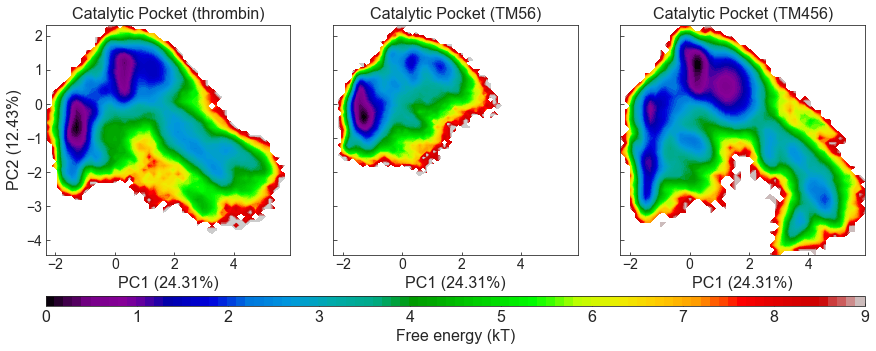

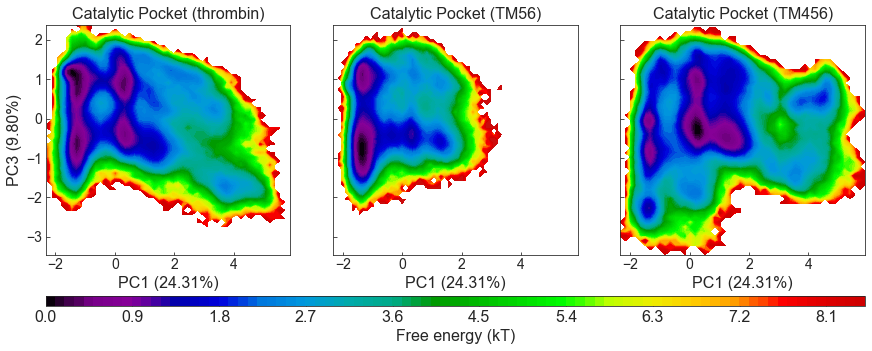

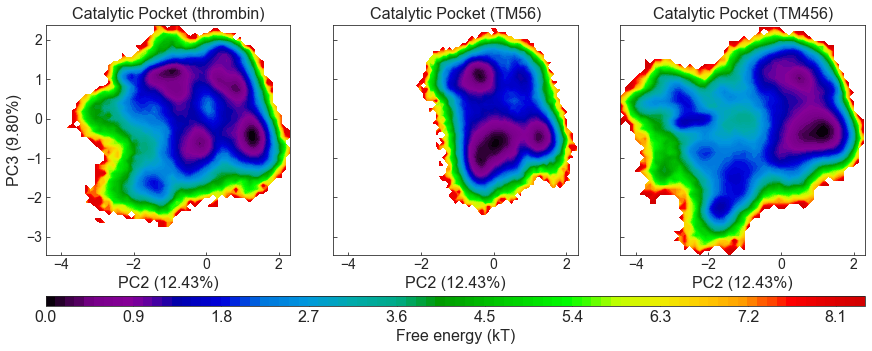

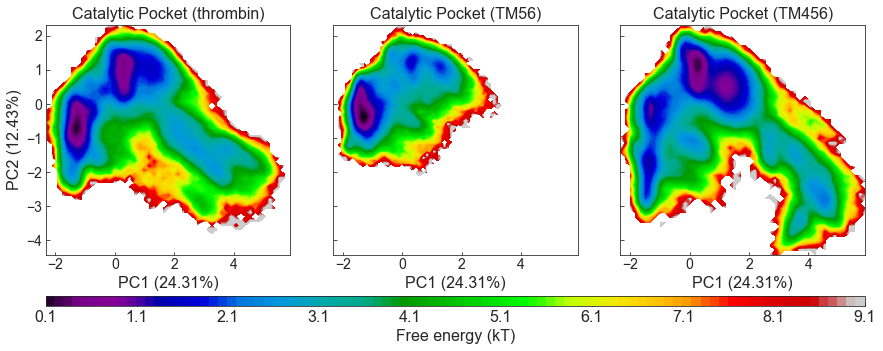

In [10]:
plot_free_energy(catalyticPocket_pca,catalyticPocket_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Catalytic Pocket','catalyticPocket')
plot_free_energy(catalyticPocket_pca,catalyticPocket_variance,0,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Catalytic Pocket','catalyticPocket')
plot_free_energy(catalyticPocket_pca,catalyticPocket_variance,1,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Catalytic Pocket','catalyticPocket')
plot_free_energy_same_min(catalyticPocket_pca,catalyticPocket_variance,0,1,
                          frames_thrombin,frames_with,frames_no,
                          0,9,'Catalytic Pocket','catalyticPocket')

In [11]:
# Regulatory Loops
regulatoryLoops_pca=np.load(path+'pca/PcaBasisFromAll/regulatoryLoops/projection.npy')
regulatoryLoops_variance=np.load(path+'pca/PcaBasisFromAll/regulatoryLoops/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/

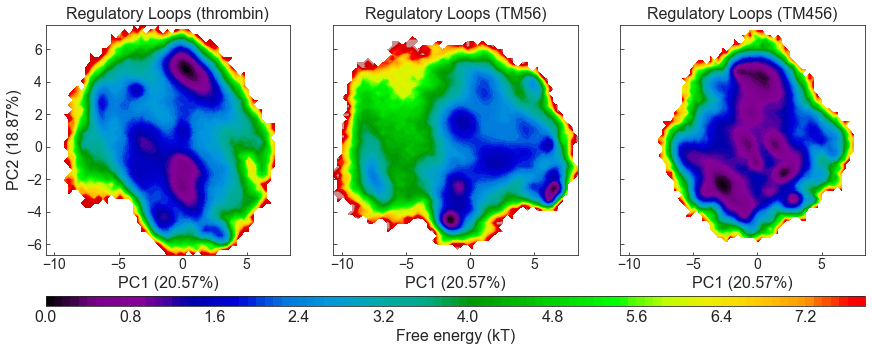

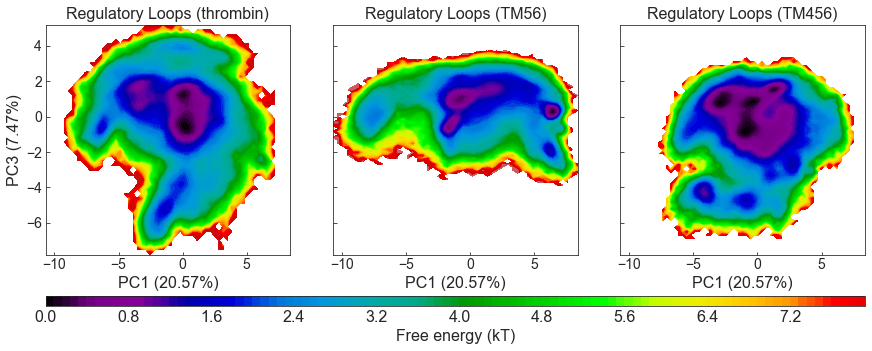

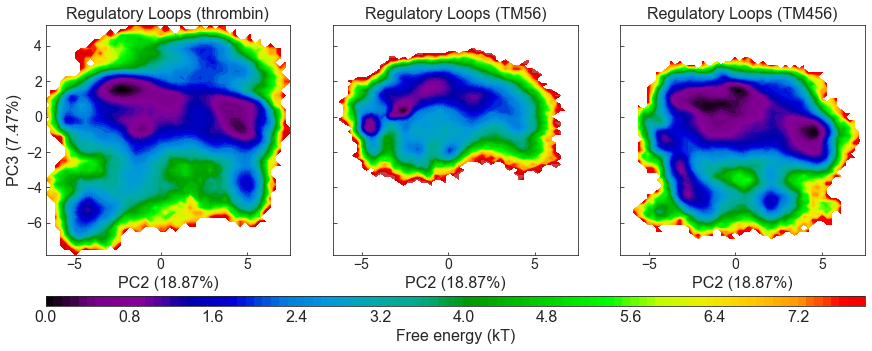

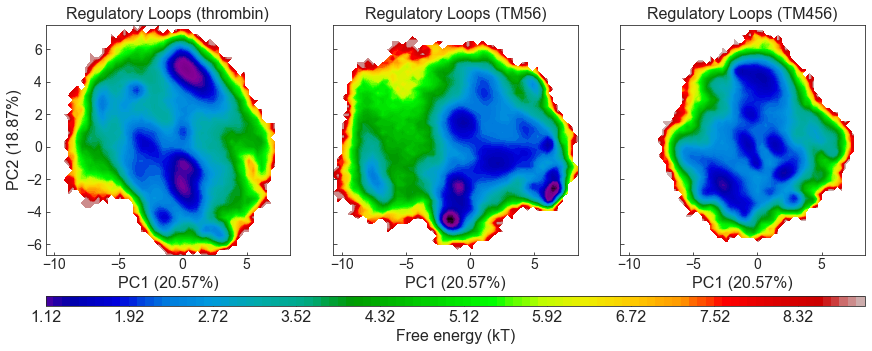

In [12]:
plot_free_energy(regulatoryLoops_pca,regulatoryLoops_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Regulatory Loops','regulatoryLoops')
plot_free_energy(regulatoryLoops_pca,regulatoryLoops_variance,0,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Regulatory Loops','regulatoryLoops')
plot_free_energy(regulatoryLoops_pca,regulatoryLoops_variance,1,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Regulatory Loops','regulatoryLoops')
plot_free_energy_same_min(regulatoryLoops_pca,regulatoryLoops_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Regulatory Loops','regulatoryLoops')

In [9]:
# 60s Loop
sixtysLoop_pca=np.load(path+'pca/PcaBasisFromAll/60sLoop/projection.npy')
sixtysLoop_variance=np.load(path+'pca/PcaBasisFromAll/60sLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/

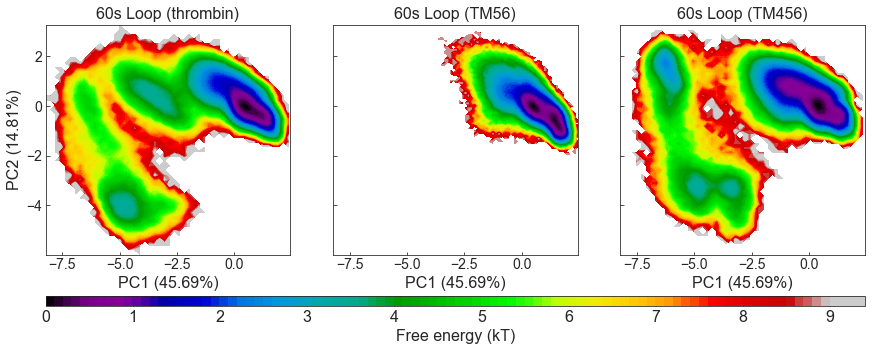

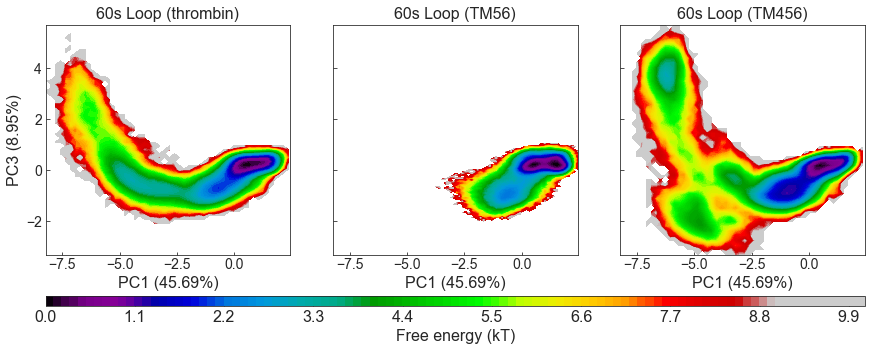

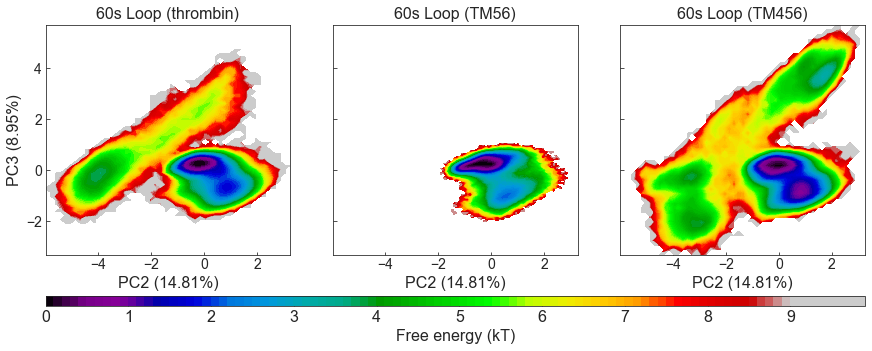

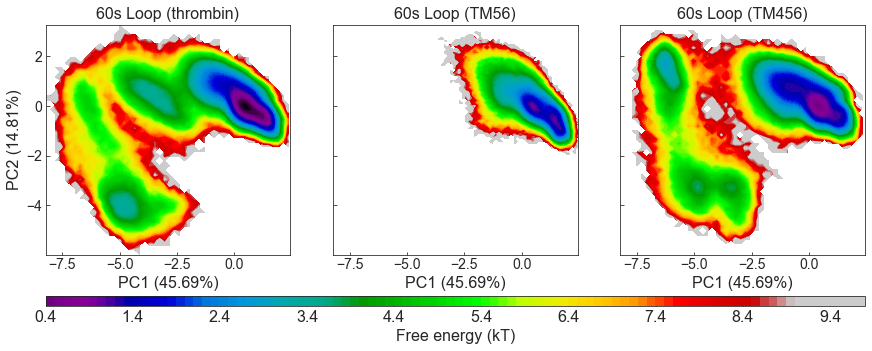

In [10]:
plot_free_energy(sixtysLoop_pca,sixtysLoop_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'60s Loop','60sLoop')
plot_free_energy(sixtysLoop_pca,sixtysLoop_variance,0,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'60s Loop','60sLoop')
plot_free_energy(sixtysLoop_pca,sixtysLoop_variance,1,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'60s Loop','60sLoop')
plot_free_energy_same_min(sixtysLoop_pca,sixtysLoop_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'60s Loop','60sLoop')

In [15]:
# Helix1 (residue 158 to 166)
helix1_pca=np.load(path+'pca/PcaBasisFromAll/helix1/projection.npy')
helix1_variance=np.load(path+'pca/PcaBasisFromAll/helix1/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/

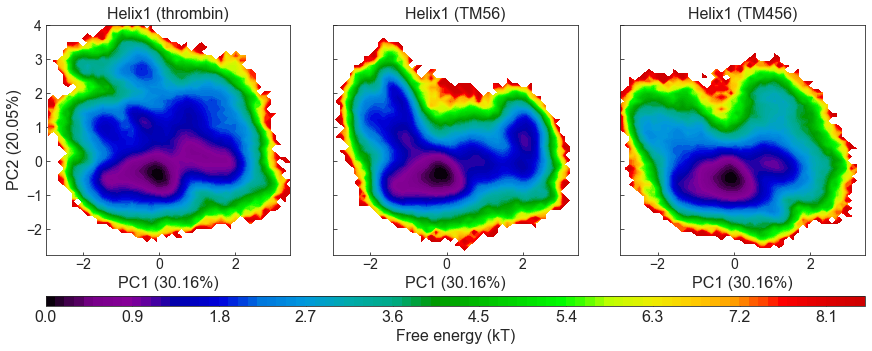

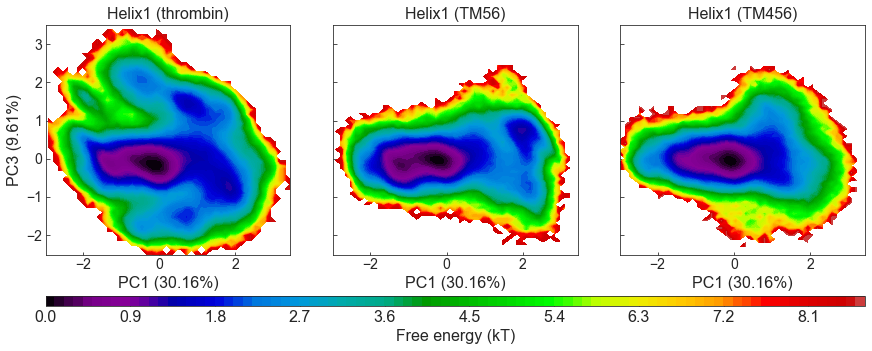

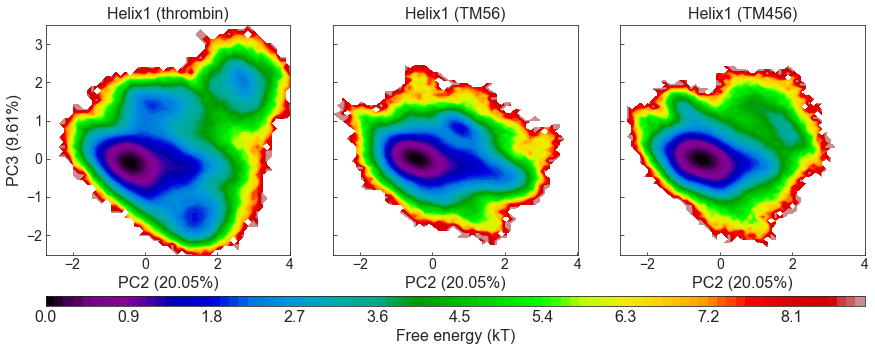

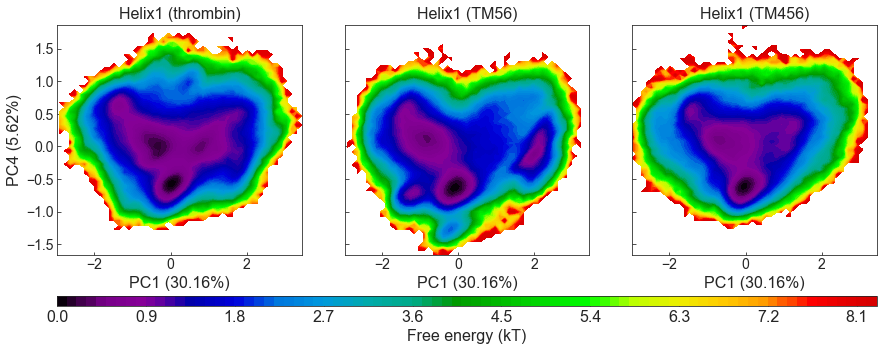

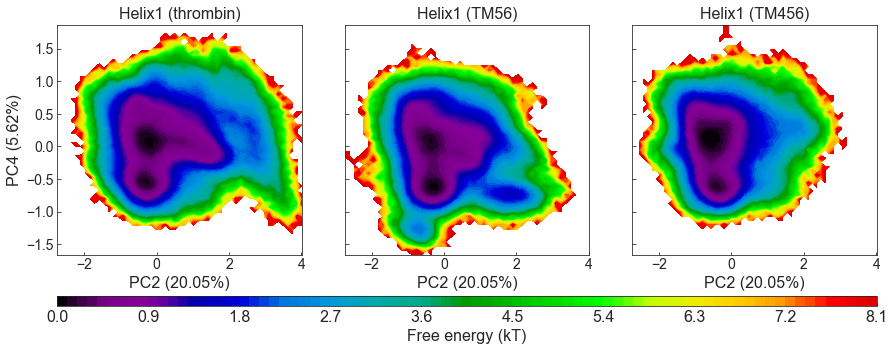

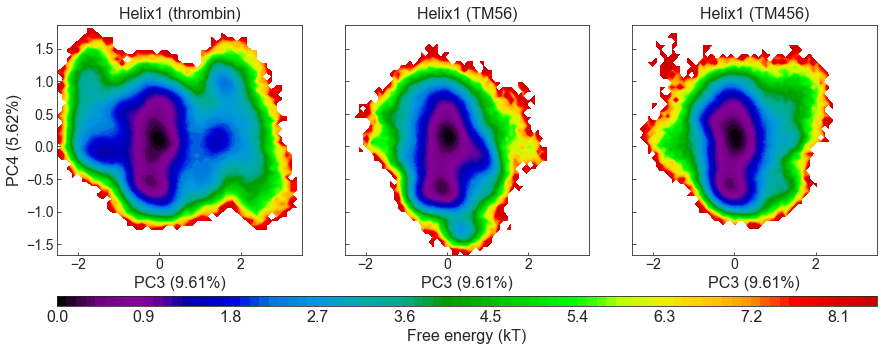

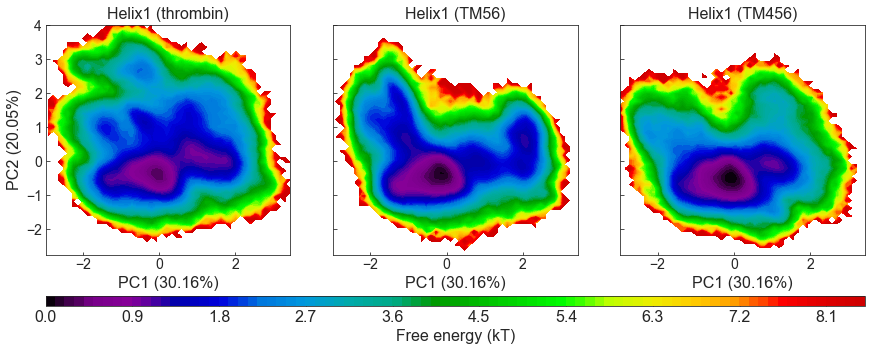

In [16]:
plot_free_energy(helix1_pca,helix1_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Helix1','helix1')
plot_free_energy(helix1_pca,helix1_variance,0,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Helix1','helix1')
plot_free_energy(helix1_pca,helix1_variance,1,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Helix1','helix1')
plot_free_energy(helix1_pca,helix1_variance,0,3,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Helix1','helix1')
plot_free_energy(helix1_pca,helix1_variance,1,3,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Helix1','helix1')
plot_free_energy(helix1_pca,helix1_variance,2,3,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Helix1','helix1')
plot_free_energy_same_min(helix1_pca,helix1_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Helix1','helix1')

In [11]:
# Gamma Loop
gammaLoop_pca=np.load(path+'pca/PcaBasisFromAll/gammaLoop/projection.npy')
gammaLoop_variance=np.load(path+'pca/PcaBasisFromAll/gammaLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/

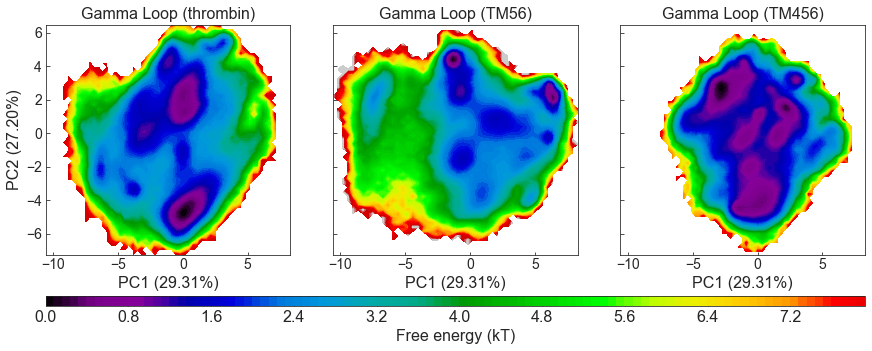

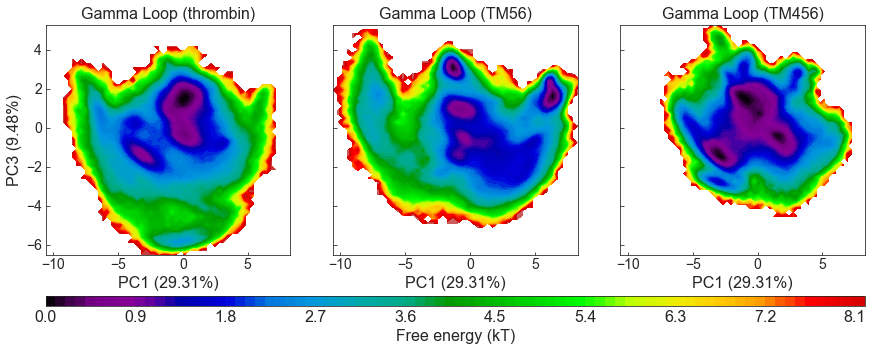

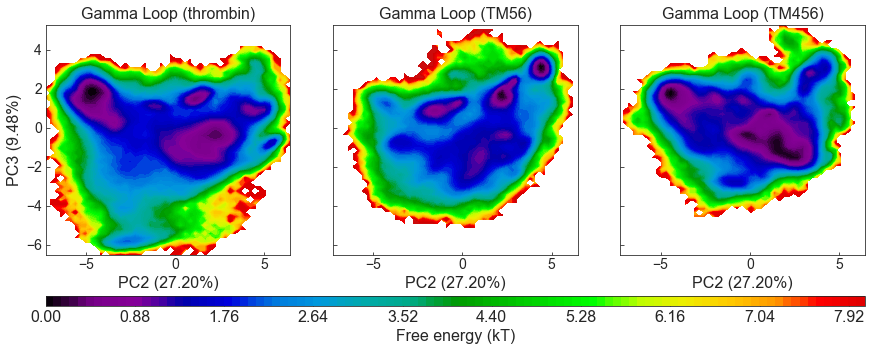

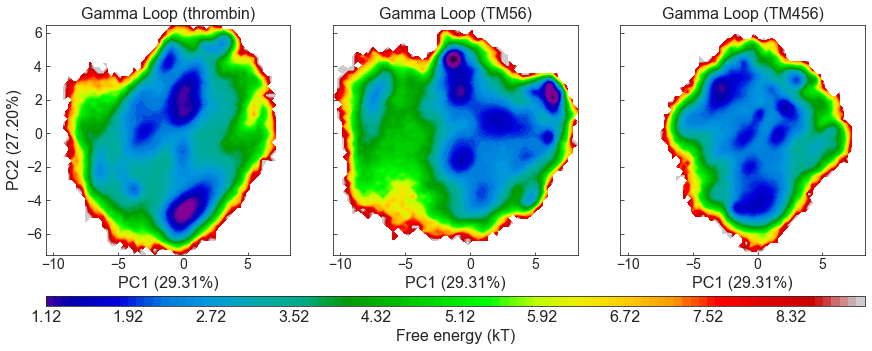

In [12]:
plot_free_energy(gammaLoop_pca,gammaLoop_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Gamma Loop','gammaLoop')
plot_free_energy(gammaLoop_pca,gammaLoop_variance,0,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Gamma Loop','gammaLoop')
plot_free_energy(gammaLoop_pca,gammaLoop_variance,1,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Gamma Loop','gammaLoop')
plot_free_energy_same_min(gammaLoop_pca,gammaLoop_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Gamma Loop','gammaLoop')

In [19]:
# 170s Loop (residue 205 to 212)
I70sLoop_pca=np.load(path+'pca/PcaBasisFromAll/170sLoop/projection.npy')
I70sLoop_variance=np.load(path+'pca/PcaBasisFromAll/170sLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/

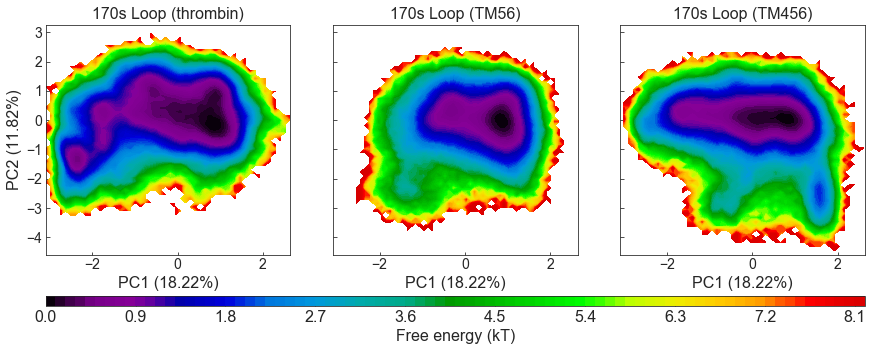

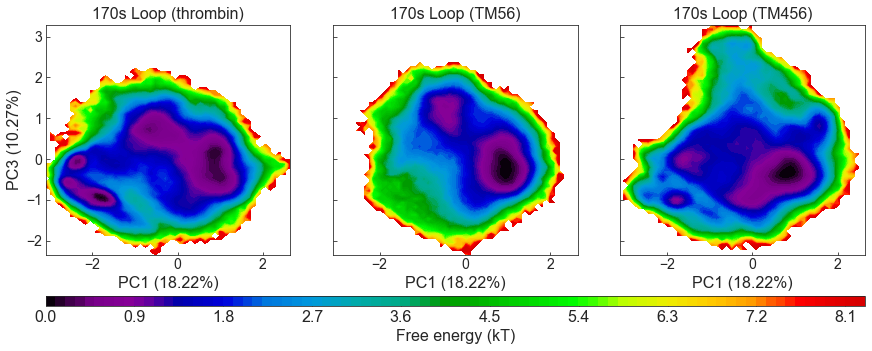

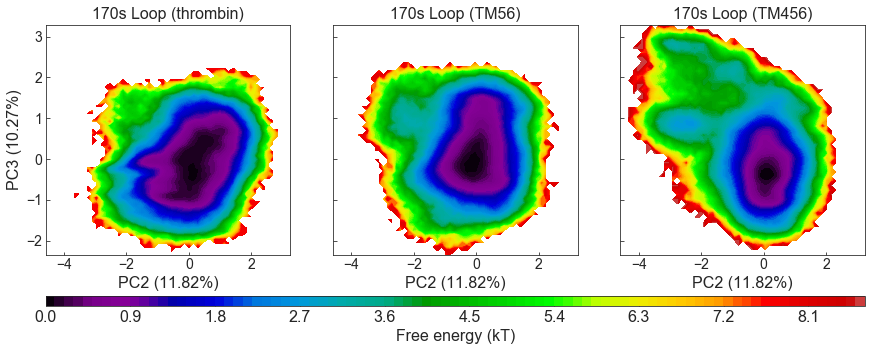

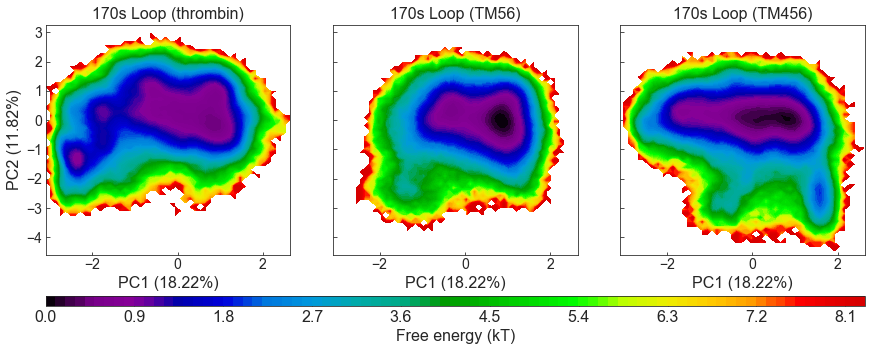

In [20]:
plot_free_energy(I70sLoop_pca,I70sLoop_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'170s Loop','170sLoop')
plot_free_energy(I70sLoop_pca,I70sLoop_variance,0,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'170s Loop','170sLoop')
plot_free_energy(I70sLoop_pca,I70sLoop_variance,1,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'170s Loop','170sLoop')
plot_free_energy_same_min(I70sLoop_pca,I70sLoop_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'170s Loop','170sLoop')

In [21]:
# 180s Loop (residue 205 to 212)
I80sLoop_pca=np.load(path+'pca/PcaBasisFromAll/180sLoop/projection.npy')
I80sLoop_variance=np.load(path+'pca/PcaBasisFromAll/180sLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/

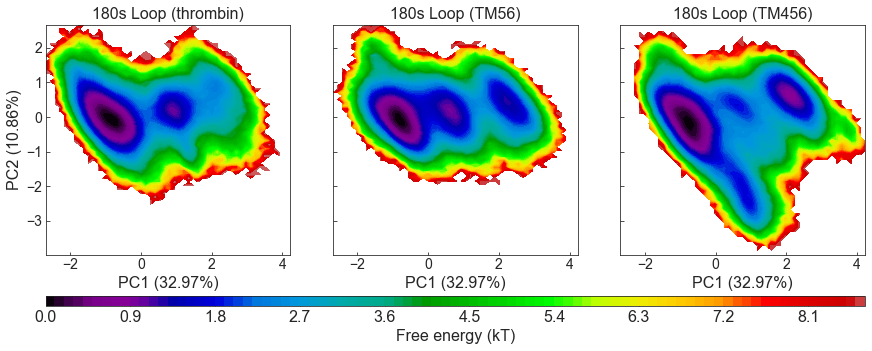

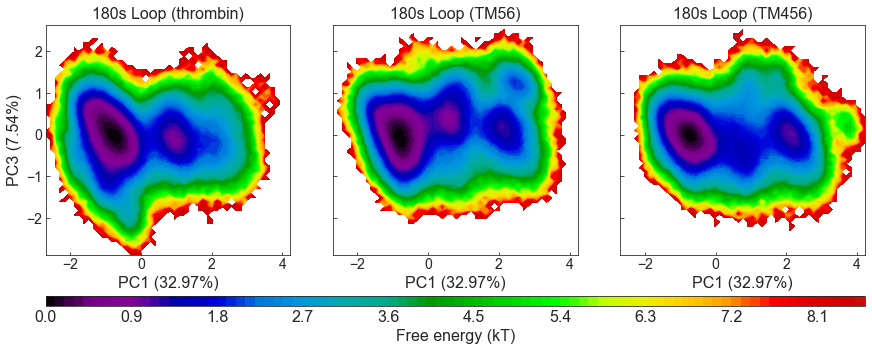

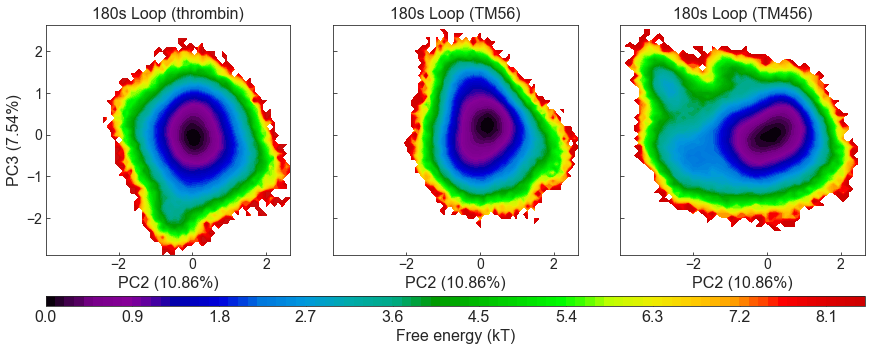

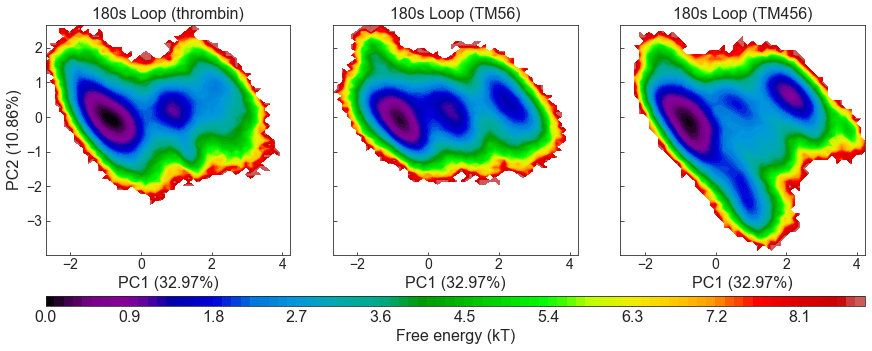

In [22]:
plot_free_energy(I80sLoop_pca,I80sLoop_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'180s Loop','180sLoop')
plot_free_energy(I80sLoop_pca,I80sLoop_variance,0,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'180s Loop','180sLoop')
plot_free_energy(I80sLoop_pca,I80sLoop_variance,1,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'180s Loop','180sLoop')
plot_free_energy_same_min(I80sLoop_pca,I80sLoop_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'180s Loop','180sLoop')

In [23]:
# Sodium Loop
sodiumLoop_pca=np.load(path+'pca/PcaBasisFromAll/sodiumLoop/projection.npy')
sodiumLoop_variance=np.load(path+'pca/PcaBasisFromAll/sodiumLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/

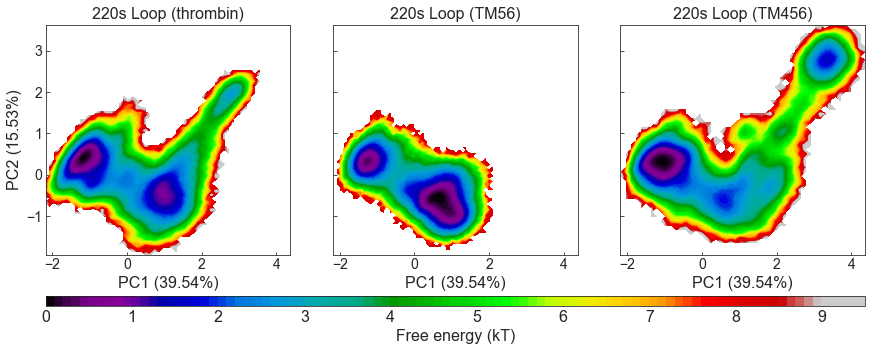

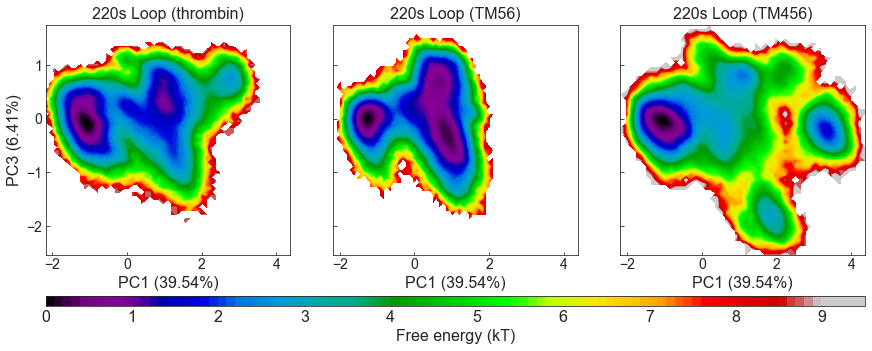

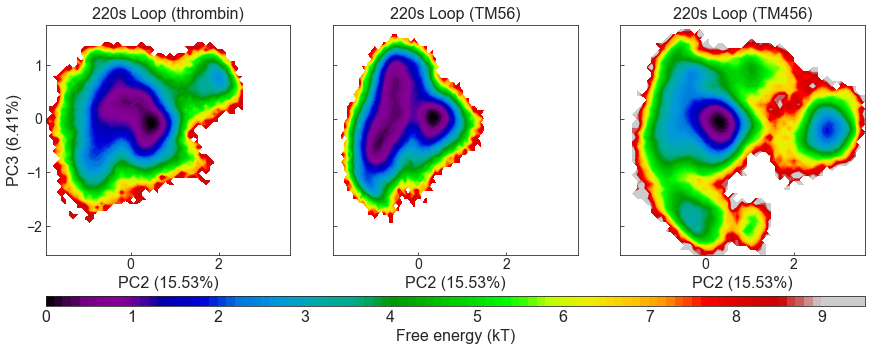

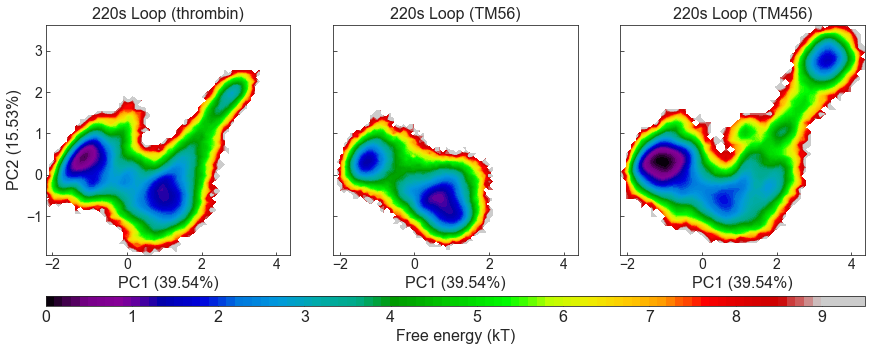

In [24]:
plot_free_energy(sodiumLoop_pca,sodiumLoop_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'220s Loop','sodiumLoop')
plot_free_energy(sodiumLoop_pca,sodiumLoop_variance,0,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'220s Loop','sodiumLoop')
plot_free_energy(sodiumLoop_pca,sodiumLoop_variance,1,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'220s Loop','sodiumLoop')
plot_free_energy_same_min(sodiumLoop_pca,sodiumLoop_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'220s Loop','sodiumLoop')

In [25]:
# Catalytic Triad
catalyticTriad_pca=np.load(path+'pca/PcaBasisFromAll/catalyticTriad/projection.npy')
catalyticTriad_variance=np.load(path+'pca/PcaBasisFromAll/catalyticTriad/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/

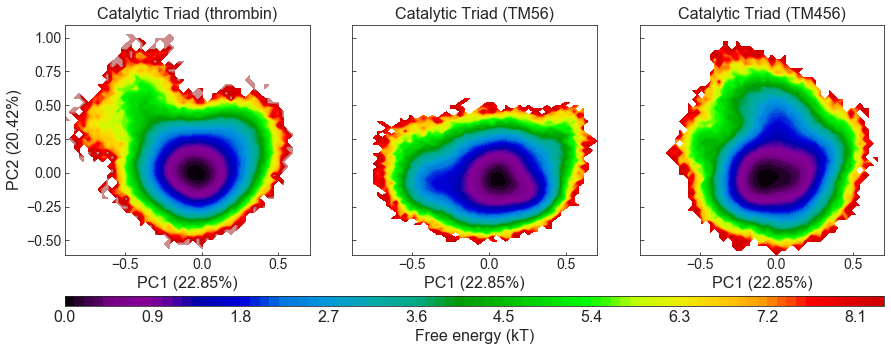

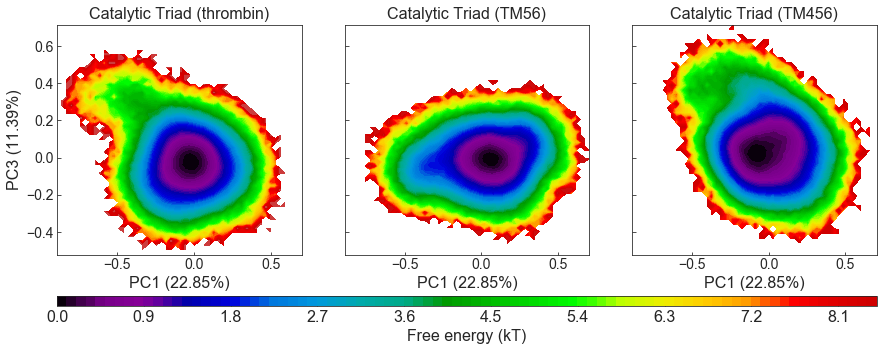

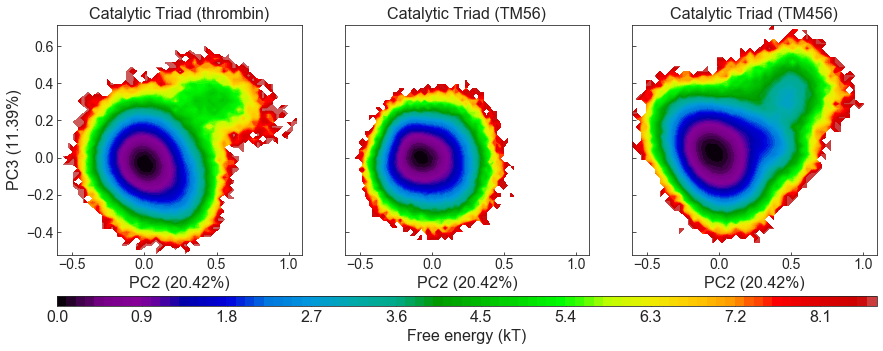

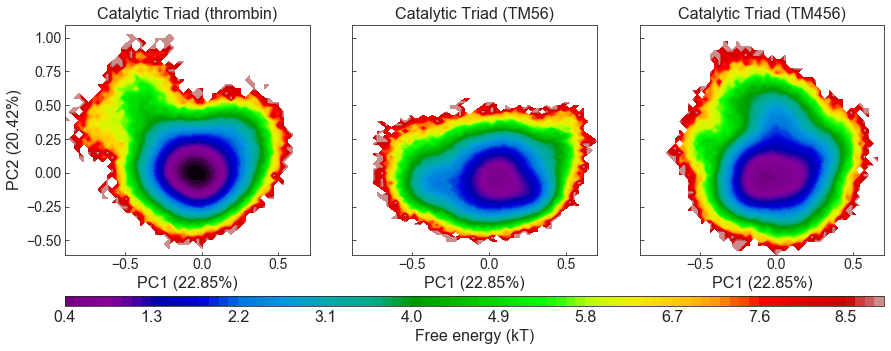

In [26]:
plot_free_energy(catalyticTriad_pca,catalyticTriad_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Catalytic Triad','catalyticTriad')
plot_free_energy(catalyticTriad_pca,catalyticTriad_variance,0,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Catalytic Triad','catalyticTriad')
plot_free_energy(catalyticTriad_pca,catalyticTriad_variance,1,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Catalytic Triad','catalyticTriad')
plot_free_energy_same_min(catalyticTriad_pca,catalyticTriad_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Catalytic Triad','catalyticTriad')

In [27]:
# Exosite I
exositeI_pca=np.load(path+'pca/PcaBasisFromAll/exositeI/projection.npy')
exositeI_variance=np.load(path+'pca/PcaBasisFromAll/exositeI/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/

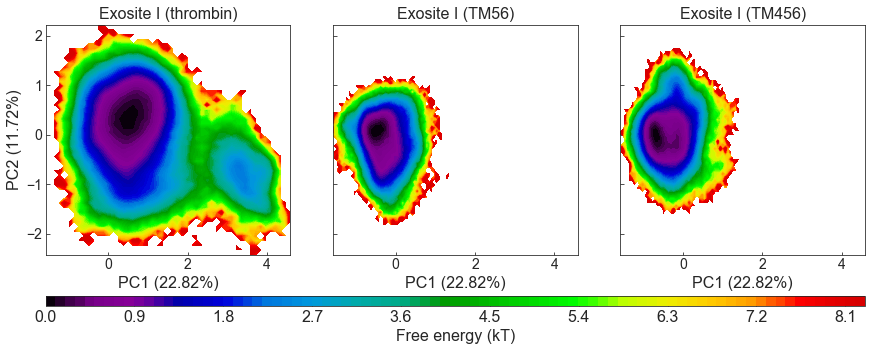

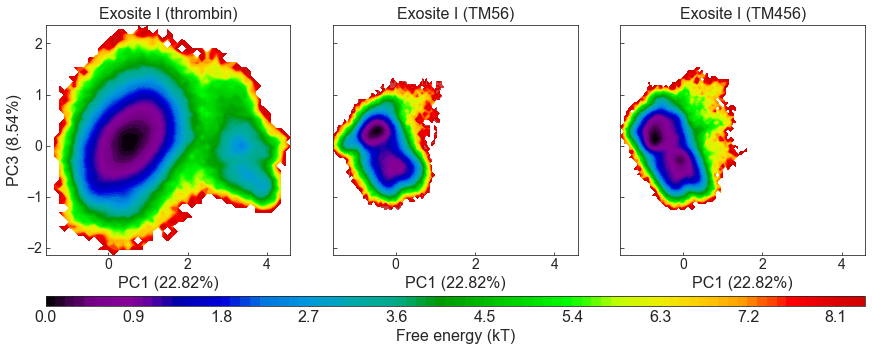

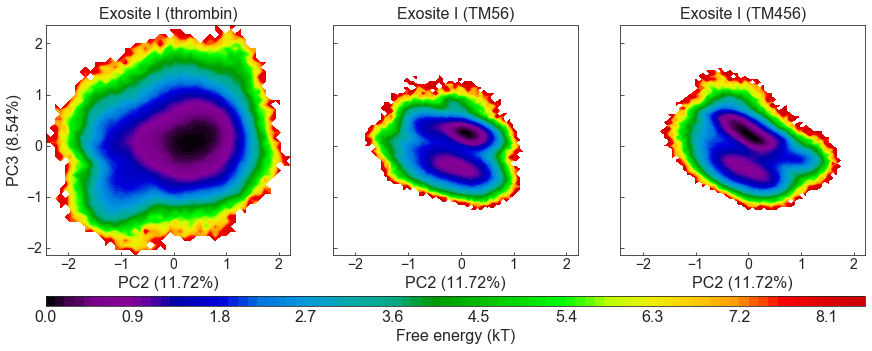

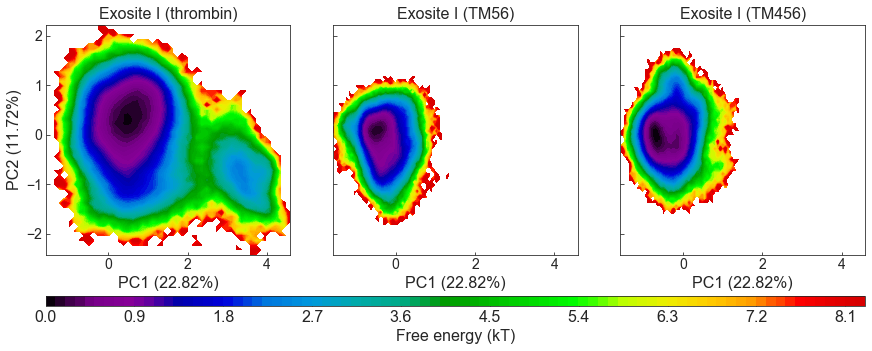

In [28]:
plot_free_energy(exositeI_pca,exositeI_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Exosite I','exositeI')
plot_free_energy(exositeI_pca,exositeI_variance,0,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Exosite I','exositeI')
plot_free_energy(exositeI_pca,exositeI_variance,1,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Exosite I','exositeI')
plot_free_energy_same_min(exositeI_pca,exositeI_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Exosite I','exositeI')

In [29]:
# Exosite II
exositeII_pca=np.load(path+'pca/PcaBasisFromAll/exositeII/projection.npy')
exositeII_variance=np.load(path+'pca/PcaBasisFromAll/exositeII/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/

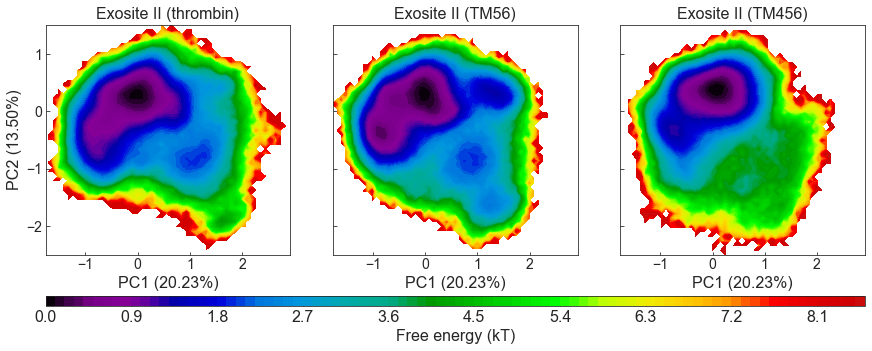

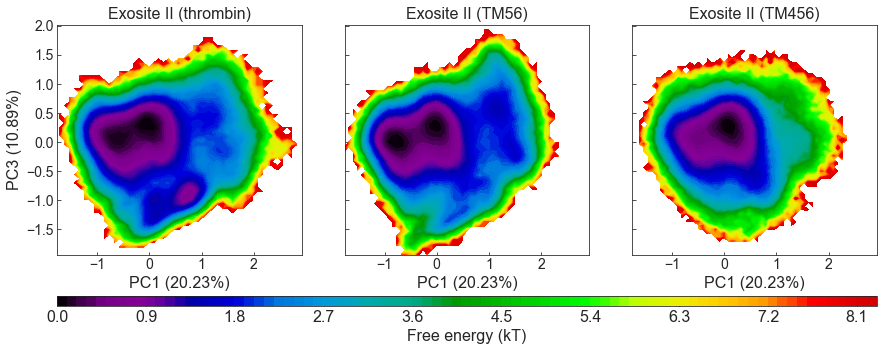

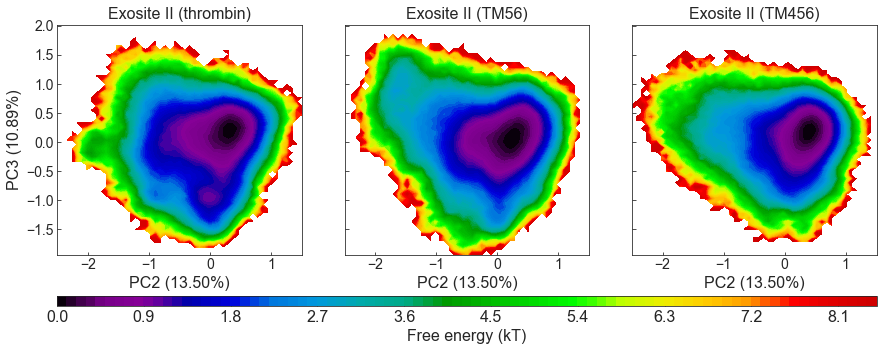

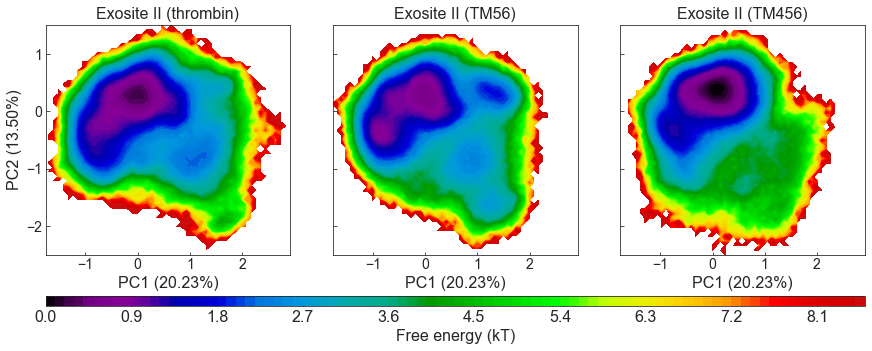

In [30]:
plot_free_energy(exositeII_pca,exositeII_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Exosite II','exositeII')
plot_free_energy(exositeII_pca,exositeII_variance,0,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Exosite II','exositeII')
plot_free_energy(exositeII_pca,exositeII_variance,1,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Exosite II','exositeII')
plot_free_energy_same_min(exositeII_pca,exositeII_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Exosite II','exositeII')

In [31]:
# Connection (residue 167 to 170)
connection_pca=np.load(path+'pca/PcaBasisFromAll/connection/projection.npy')
connection_variance=np.load(path+'pca/PcaBasisFromAll/connection/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/

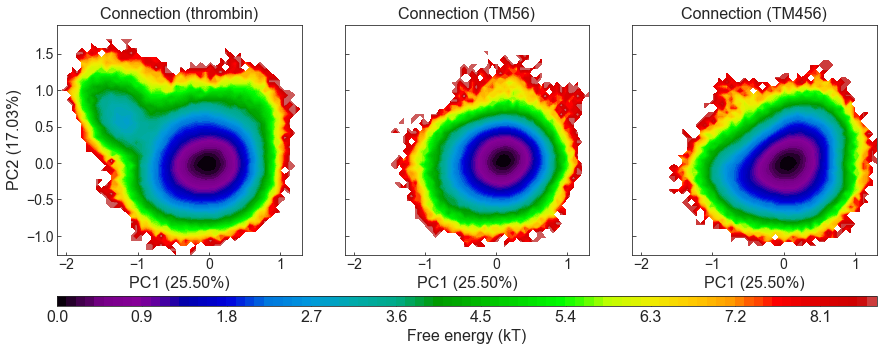

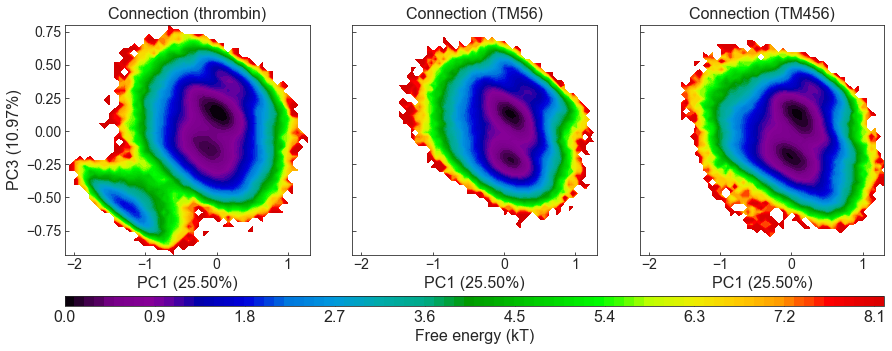

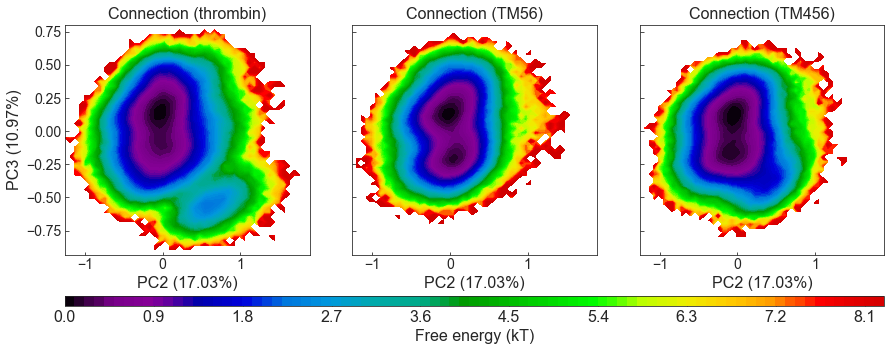

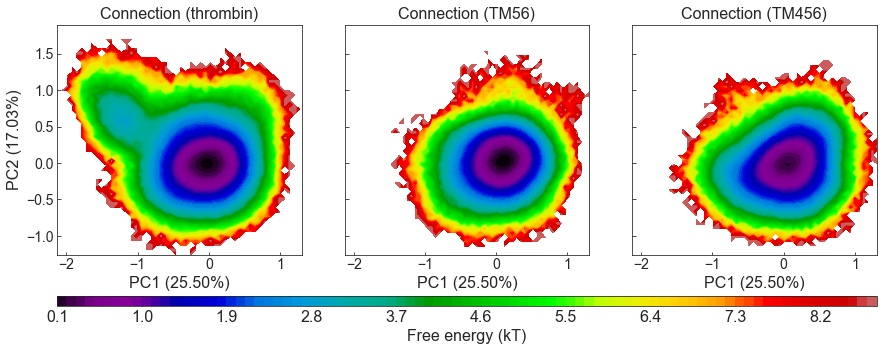

In [32]:
plot_free_energy(connection_pca,connection_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Connection','connection')
plot_free_energy(connection_pca,connection_variance,0,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Connection','connection')
plot_free_energy(connection_pca,connection_variance,1,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'Connection','connection')
plot_free_energy_same_min(connection_pca,connection_variance,0,1,
                          frames_thrombin,frames_with,frames_no,
                          0,9,'Connection','connection')

In [33]:
# 30s Loop
thirtysLoop_pca=np.load(path+'pca/PcaBasisFromAll/30sLoop/projection.npy')
thirtysLoop_variance=np.load(path+'pca/PcaBasisFromAll/30sLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/wud18/install/anaconda3/envs/

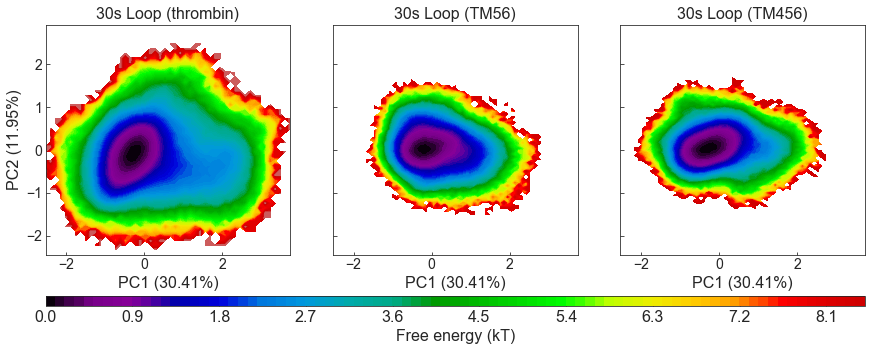

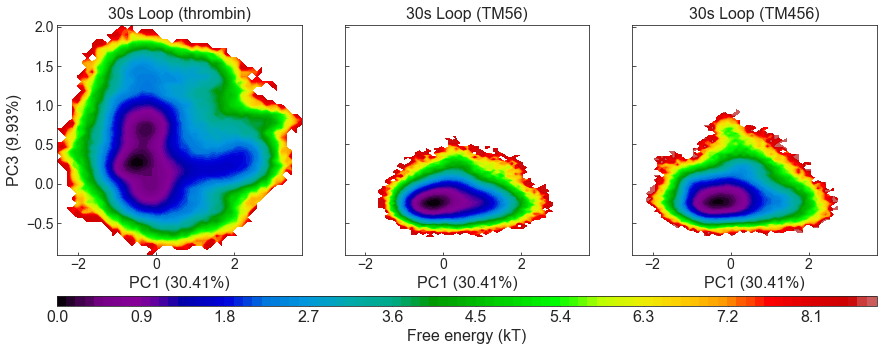

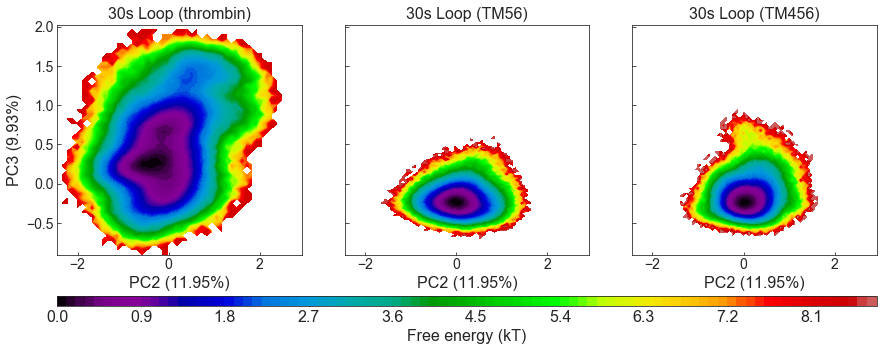

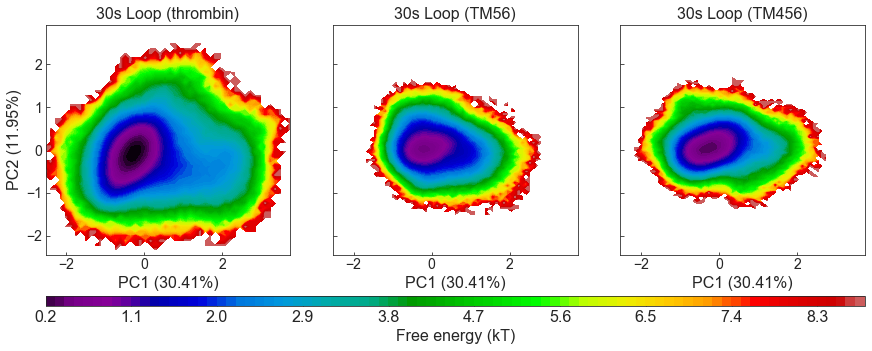

In [34]:
plot_free_energy(thirtysLoop_pca,thirtysLoop_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'30s Loop','30sLoop')
plot_free_energy(thirtysLoop_pca,thirtysLoop_variance,0,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'30s Loop','30sLoop')
plot_free_energy(thirtysLoop_pca,thirtysLoop_variance,1,2,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'30s Loop','30sLoop')
plot_free_energy_same_min(thirtysLoop_pca,thirtysLoop_variance,0,1,
                 frames_thrombin,frames_with,frames_no,
                 0,9,'30s Loop','30sLoop')

In [35]:
# Helix2 (residue 205 to 212)
helix2_pca=np.load(path+'pca/PcaBasisFromAll/helix2/projection.npy')
helix2_variance=np.load(path+'pca/PcaBasisFromAll/helix2/variance.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/deac/salsburyGrp/wud18/md/TM/pca/PcaBasisFromAll/helix2/projection.npy'

In [ ]:
plot_free_energy(helix2_pca,helix2_variance,0,1,
                 frames_bigger,frames_double,frames_outer,frames_inner,
                 0,9,'Helix2','helix2')
plot_free_energy(helix2_pca,helix2_variance,0,2,
                 frames_bigger,frames_double,frames_outer,frames_inner,
                 0,9,'Helix2','helix2')
plot_free_energy(helix2_pca,helix2_variance,1,2,
                 frames_bigger,frames_double,frames_outer,frames_inner,
                 0,9,'Helix2','helix2')
plot_free_energy_same_min(helix2_pca,helix2_variance,0,1,
                 frames_bigger,frames_double,frames_outer,frames_inner,
                 0,9,'Helix2','helix2')

In [ ]:
# Beta Sheet1 (residue 171 to 176)
betaSheet1_pca=np.load(path+'pca/PcaBasisFromAll/betaSheet1/projection.npy')
betaSheet1_variance=np.load(path+'pca/PcaBasisFromAll/betaSheet1/variance.npy')

In [ ]:
plot_free_energy(betaSheet1_pca,betaSheet1_variance,0,1,
                 frames_bigger,frames_double,frames_outer,frames_inner,
                 0,9,'Beta Sheet1','betaSheet1')
plot_free_energy(betaSheet1_pca,betaSheet1_variance,0,2,
                 frames_bigger,frames_double,frames_outer,frames_inner,
                 0,9,'Beta Sheet1','betaSheet1')
plot_free_energy(betaSheet1_pca,betaSheet1_variance,1,2,
                 frames_bigger,frames_double,frames_outer,frames_inner,
                 0,9,'Beta Sheet1','betaSheet1')
plot_free_energy_same_min(betaSheet1_pca,betaSheet1_variance,0,1,
                          frames_bigger,frames_double,frames_outer,frames_inner,
                          0,9,'Beta Sheet1','betaSheet1')

In [ ]:
# Connection Beta Sheet1 (residue 167 to 176)
connectionBetaSheet1_pca=np.load(path+'pca/PcaBasisFromAll/connectionBetaSheet1/projection.npy')
connectionBetaSheet1_variance=np.load(path+'pca/PcaBasisFromAll/connectionBetaSheet1/variance.npy')

In [ ]:
plot_free_energy(connectionBetaSheet1_pca,connectionBetaSheet1_variance,0,1,
                 frames_bigger,frames_double,frames_outer,frames_inner,
                 0,9,'Connection Beta Sheet1','connectionBetaSheet1')
plot_free_energy(connectionBetaSheet1_pca,connectionBetaSheet1_variance,0,2,
                 frames_bigger,frames_double,frames_outer,frames_inner,
                 0,9,'Connection Beta Sheet1','connectionBetaSheet1')
plot_free_energy(connectionBetaSheet1_pca,connectionBetaSheet1_variance,1,2,
                 frames_bigger,frames_double,frames_outer,frames_inner,
                 0,9,'Connection Beta Sheet1','connectionBetaSheet1')
plot_free_energy_same_min(connectionBetaSheet1_pca,connectionBetaSheet1_variance,0,1,
                          frames_bigger,frames_double,frames_outer,frames_inner,
                          0,9,'Connection Beta Sheet1','connectionBetaSheet1')

In [ ]:
# Helix1 Connection Beta Sheet1 (residue 158 to 176)
helix1ConnectionBetaSheet1_pca=np.load(path+'pca/PcaBasisFromAll/helix1ConnectionBetaSheet1/projection.npy')
helix1ConnectionBetaSheet1_variance=np.load(path+'pca/PcaBasisFromAll/helix1ConnectionBetaSheet1/variance.npy')

In [ ]:
plot_free_energy(helix1ConnectionBetaSheet1_pca,helix1ConnectionBetaSheet1_variance,0,1,
                 frames_bigger,frames_double,frames_outer,frames_inner,
                 0,9,'Helix1 Connection Beta Sheet1','helix1ConnectionBetaSheet1')
plot_free_energy(helix1ConnectionBetaSheet1_pca,helix1ConnectionBetaSheet1_variance,0,2,
                 frames_bigger,frames_double,frames_outer,frames_inner,
                 0,9,'Helix1 Connection Beta Sheet1','helix1ConnectionBetaSheet1')
plot_free_energy(helix1ConnectionBetaSheet1_pca,helix1ConnectionBetaSheet1_variance,1,2,
                 frames_bigger,frames_double,frames_outer,frames_inner,
                 0,9,'Helix1 Connection Beta Sheet1','helix1ConnectionBetaSheet1')
plot_free_energy_same_min(helix1ConnectionBetaSheet1_pca,helix1ConnectionBetaSheet1_variance,0,1,
                          frames_bigger,frames_double,frames_outer,frames_inner,
                          0,9,'Helix1 Connection Beta Sheet1','helix1ConnectionBetaSheet1')

In [ ]:
# Examine Wells

In [ ]:
def examine_well(X,Y,indices,leftEdge, rightEdge, lowerEdge, upperEdge, sampleSize, outputName):
    boolean_in_X = np.logical_and(X[indices]<rightEdge, X[indices]>leftEdge)
    boolean_in_Y = np.logical_and(Y[indices]<upperEdge, Y[indices]>lowerEdge)
    boolean_in_XY = np.logical_and(boolean_in_X, boolean_in_Y)
    #print('# of frames within the selected window',boolean_in_XY.sum())
    
    # Find the most populated bin within the selected window
    nbins=100
    numOfSamplesInABin=250
    z=np.array([1])
    while z.max()<numOfSamplesInABin: # make sure to have enough samples
        #print(nbins)
        z,xedges,yedges = np.histogram2d(X[indices[boolean_in_XY]],Y[indices[boolean_in_XY]],bins=nbins)
        #print(z.max())
        nbins -=10
    bin_x,bin_y=np.unravel_index(np.argmax(z),z.shape)
    boolean_in_X = np.logical_and(X[indices]<xedges[bin_x+1],X[indices]>xedges[bin_x])
    boolean_in_Y = np.logical_and(Y[indices]<yedges[bin_y+1],Y[indices]>yedges[bin_y])
    boolean_in_XY = np.logical_and(boolean_in_X, boolean_in_Y)
    print('# of frames within the most populated bin',boolean_in_XY.sum())
    
    # Find the representative frame
    binAverage_x = X[indices[boolean_in_XY]].mean()
    binAverage_y = Y[indices[boolean_in_XY]].mean()
    distance2ToBinCenter = (X[indices[boolean_in_XY]]-binAverage_x)**2 + \
    (Y[indices[boolean_in_XY]]-binAverage_y)**2
    representativeFrame = (indices[boolean_in_XY])[np.argmin(distance2ToBinCenter)]
    print("representativeFrame",representativeFrame)
    
    # Sample from the most populated bin
    sampledFramesInSelectedWells = np.random.choice(indices[boolean_in_XY],sampleSize).astype(int)
    sampledFramesInSelectedWells[0]=representativeFrame
    print("sampledFrames\n",sampledFramesInSelectedWells)
    
    # Check the location of the samples
    mplt.plot_free_energy(X[indices], Y[indices], kT=0.593, cbar_label='kcal/mol')
    scatter(X[sampledFramesInSelectedWells], Y[sampledFramesInSelectedWells], alpha=0.3, color='white')
    text(X[representativeFrame], Y[representativeFrame],'X', fontsize=15, color='white', horizontalalignment='center', verticalalignment='center')

    # Write output files
    representative_frame = md.load_frame(trajfile,representativeFrame,top = topfile)
    representative_frame.save_pdb(outputName+'_Representative.pdb')   
    pca_well_sample = np.column_stack((np.zeros(sampledFramesInSelectedWells.size),sampledFramesInSelectedWells))
    pca_well_sample=pca_well_sample.astype(int)
    coor.save_traj(inp, pca_well_sample, outputName+'.dcd')
    
    return sampledFramesInSelectedWells

In [ ]:
stride=1
topfile = '/deac/salsburyGrp/wud18/md/thrombin/WT_dK9_E8K_R4A/protein.pdb'
topology = md.load(topfile).topology
trajfile = '/deac/salsburyGrp/wud18/md/thrombin/WT_dK9_E8K_R4A/protein_stride' + str(stride) + '_aligned.dcd'
feat = coor.featurizer(topfile)

In [ ]:
s1 = feat.select("(residue 79 or residue 235 to 241 or residue 261 to 264 or residue 266 or residue 267 or residue 268 or residue 274 or residue 275) and element != 'H'")
s2 = feat.select("(residue 79 or residue 83 or residue 86 or residue 132 or residue 238 or residue 262 or residue 263) and element != 'H'")
s3 = feat.select("(residue 86 or residue 263 to 266) and element != 'H'")
s4 = feat.select("(residue 213 or residue 215 or residue 263 to 265) and element != 'H'")
s5 = feat.select("(residue 215 or residue 265) and element != 'H'")
s6 = feat.select("(residue 214 to 215) and element != 'H'")
catalyticTriad = feat.select("(residue 79 or residue 135 or residue 241) and element != 'H'")
catalytic = np.unique(np.concatenate((s1,s2,s3,s4,s5,s6,catalyticTriad)))
print('selection index:\n',catalytic)
print('\nnumber of atoms:\n',len(catalytic))
feat.add_selection(catalytic)
feat.describe()[:10]
inp = coor.source(trajfile, feat)
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())

In [ ]:
# Visualizing catalytic pocket

In [ ]:
cd /deac/salsburyGrp/wud18/md/thrombin/pca/PcaBasisFromAll/catalyticPocket_new

In [ ]:
examine_well(catalyticPocket_pca[:,0],catalyticPocket_pca[:,1],frames_WTOn,-2,1,-1,1,100,'cluster1');

In [ ]:
examine_well(catalyticPocket_pca[:,0],catalyticPocket_pca[:,1],frames_WTOn,-1,0,-2.5,-1.5,100,'cluster2');

In [ ]:
examine_well(catalyticPocket_pca[:,0],catalyticPocket_pca[:,1],frames_dK9On,3,5,1,2,100,'cluster3');

In [ ]:
examine_well(catalyticPocket_pca[:,0],catalyticPocket_pca[:,1],frames_dK9On,0,2,0,1,100,'cluster4');

In [ ]:
examine_well(catalyticPocket_pca[:,0],catalyticPocket_pca[:,1],frames_dK9On,1,3,-2,-1,100,'cluster5');

In [ ]:
examine_well(catalyticPocket_pca[:,0],catalyticPocket_pca[:,1],frames_dK9Off,-1,1,0.5,2,100,'cluster6');

In [ ]:
examine_well(catalyticPocket_pca[:,0],catalyticPocket_pca[:,1],frames_dK9Off,4,6,-1,0.5,100,'cluster7');

In [ ]:
examine_well(catalyticPocket_pca[:,0],catalyticPocket_pca[:,1],frames_E8KOn,4,6,-1.5,1,100,'cluster8');

In [ ]:
# Visualizing regulatory loops

In [ ]:
cd /deac/salsburyGrp/wud18/md/thrombin/pca/PcaBasisFromAll/regulatoryLoops_new

In [ ]:
examine_well(regulatoryLoops_pca[:,0],regulatoryLoops_pca[:,1],frames_WTOn,-4,-2,0,2,100,'cluster1');

In [ ]:
examine_well(regulatoryLoops_pca[:,0],regulatoryLoops_pca[:,1],frames_WTOn,-2,0,-2,0,100,'cluster2');

In [ ]:
examine_well(regulatoryLoops_pca[:,0],regulatoryLoops_pca[:,1],frames_WTOn,0,2,-3,-1,100,'cluster3');

In [ ]:
examine_well(regulatoryLoops_pca[:,0],regulatoryLoops_pca[:,1],frames_dK9On,3,5,-4,0,100,'cluster4');

In [ ]:
examine_well(regulatoryLoops_pca[:,0],regulatoryLoops_pca[:,1],frames_dK9On,4,7,0,4,100,'cluster5');

In [ ]:
examine_well(regulatoryLoops_pca[:,0],regulatoryLoops_pca[:,1],frames_dK9Off,2,4,-4,-2,100,'cluster6');

In [ ]:
examine_well(regulatoryLoops_pca[:,0],regulatoryLoops_pca[:,1],frames_dK9Off,4,8,0,4,100,'cluster7');

In [ ]:
examine_well(regulatoryLoops_pca[:,0],regulatoryLoops_pca[:,1],frames_dK9Off,0,6,5,9,100,'cluster8');

In [ ]:
examine_well(regulatoryLoops_pca[:,0],regulatoryLoops_pca[:,1],frames_E8KOn,-1,2,0,4,100,'cluster9');

In [ ]:
examine_well(regulatoryLoops_pca[:,0],regulatoryLoops_pca[:,1],frames_E8KOn,2,4,3,6,100,'cluster10');